# Alone factor

To get an idea of how 'alone' each mutation is, we have to find the alone-factor for each mutation. This can be done by going through each patient, finding how many- and which mutations they have. Then, for each patient, their mutations get a value of 1/#-mutations. After this, we can examine the distribution of alone-factors for each mutation.

## Setup

In [1]:
library("ggplot2")
library('dplyr')
library('RColorBrewer')
library('data.table')

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




## Get data

In [2]:
# Getting the mutation dataset where duplicates are removed
mutation_data_de_duplicated <- read.csv("../../derived_data/genie_v15/mutation_no_duplicates.csv", header=TRUE, stringsAsFactors=FALSE)

# Removing two columns only containing indexes
mutation_data_de_duplicated <- mutation_data_de_duplicated[,-1:-2]

# Checking the data
dim(mutation_data_de_duplicated)
#head(mutation_data_de_duplicated)

[1] 163844      7

In [3]:
# Getting the full mutation dataset
mutation_data <- read.table("../../data/genie_v15/data_mutations_extended.txt", sep="\t", quote="", head=TRUE)

# Checking the data
dim(mutation_data)
#head(mutation_data)

[1] 1840311      64

In [4]:
# Getting sample data
sample_data <- read.table("../../data/genie_v15/data_clinical_sample.txt", sep="\t", quote="", head=TRUE)

# Only keeping sample- and patient-ID
sample_data <- sample_data %>% select(PATIENT_ID,SAMPLE_ID,SEQ_ASSAY_ID)

# Chekcing the result
dim(sample_data)
head(sample_data)

[1] 198041      3

,PATIENT_ID,SAMPLE_ID,SEQ_ASSAY_ID
,<chr>,<chr>,<chr>
1,GENIE-VICC-101416,GENIE-VICC-101416-unk-1,VICC-01-T7
2,GENIE-VICC-102225,GENIE-VICC-102225-unk-1,VICC-01-T7
3,GENIE-VICC-102424,GENIE-VICC-102424-unk-1,VICC-01-T7
4,GENIE-VICC-102966,GENIE-VICC-102966-unk-1,VICC-01-T7
5,GENIE-VICC-103244,GENIE-VICC-103244-unk-1,VICC-01-T5A
6,GENIE-VICC-103477,GENIE-VICC-103477-unk-1,VICC-01-D2


In [5]:
panel_length <- read.csv("../../derived_data/genie_v15/panel_length_table.csv", header=TRUE, stringsAsFactors=FALSE)

panel_length <- panel_length[,-1]

dim(panel_length)
head(panel_length)

[1] 112   2

,Assay_ID,length_in_bp
,<chr>,<int>
1,UHN-48-V1,529200
2,UHN-50-V2,308378
3,GRCC-CHP2,330405
4,GRCC-CP1,332685
5,GRCC-MOSC3,2276205
6,NKI-TSACP-MISEQ-NGS,567000


## Alone-factor

In [6]:
# Creating a vector containing all the samples we want to keep, the ones without duplicates
keep <- unique(mutation_data_de_duplicated$SAMPLE_ID)

# Creating a new table containing mutation data for the samples we want to keep
my_table <- mutation_data[which(mutation_data$Tumor_Sample_Barcode %in% keep),]

# Renaming one of the columns to make merging better
sample_data <- rename(sample_data, Assay_ID = SEQ_ASSAY_ID)

# Doing an inner-join so we only keep data where the patient-ID is known
sample_data <- inner_join(sample_data, panel_length, join_by(Assay_ID))

# Renaming one of the columns to make merging better
my_table <- rename(my_table, SAMPLE_ID = Tumor_Sample_Barcode)

# Doing an inner-join so we only keep data where the patient-ID is known
my_table <- inner_join(my_table, sample_data, join_by(SAMPLE_ID))

# Selecting only a subset of the columns we need
my_table <- my_table %>% select(Hugo_Symbol, SAMPLE_ID, PATIENT_ID, length_in_bp)

# Creating a new data-table containing a count of how often each patient occurs in the dataset
count <- as.data.frame(table(my_table$PATIENT_ID))

# Renaming the columns in count
count <- rename(count, PATIENT_ID = Var1)
count <- rename(count, count = Freq)

# Then doing an inner-join to add count to my_table
my_table <- inner_join(my_table, count, join_by(PATIENT_ID))

# Creating the alone-factor column based on count
my_table$alone_factor <- 1/my_table$count

In [7]:
# Checking how many patients are used for finding the alone-factor
length(unique(my_table$PATIENT_ID))

# Cehcking teh result
dim(my_table)
head(my_table)

[1] 144568

[1] 1594281       6

,Hugo_Symbol,SAMPLE_ID,PATIENT_ID,length_in_bp,count,alone_factor
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
1,KRAS,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556
2,BRAF,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556
3,EGFR,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556
4,TP53,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556
5,NRAS,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556
6,PIK3CA,GENIE-JHU-00006-00185,GENIE-JHU-00006,352432,18,0.05555556


## Plots

In [8]:
# Creating a new data-frame with the mutations with an alone-factor of 1
single <- my_table[which(my_table$alone_factor==1),]

# Counting how many often the different mutations occur int he table
single <- as.data.frame(table(single$Hugo_Symbol))

# Sorting the table by the frequency
single <- single[order(-single$Freq), ]

# Seeing the 10 most frequenct mutations with an alone-factor of 1
single[1:10,]

,Var1,Freq
,<fct>,<int>
643,TP53,4055
331,KRAS,1630
58,BRAF,1126
456,PIK3CA,692
417,NRAS,480
155,EGFR,476
323,KIT,420
310,JAK2,347
494,PTEN,224


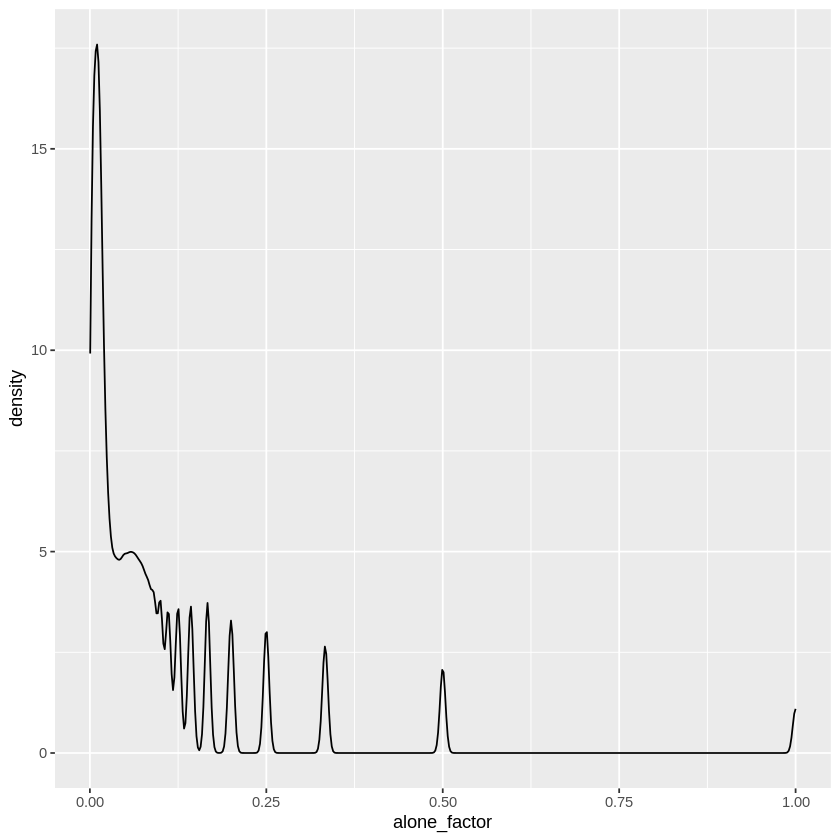

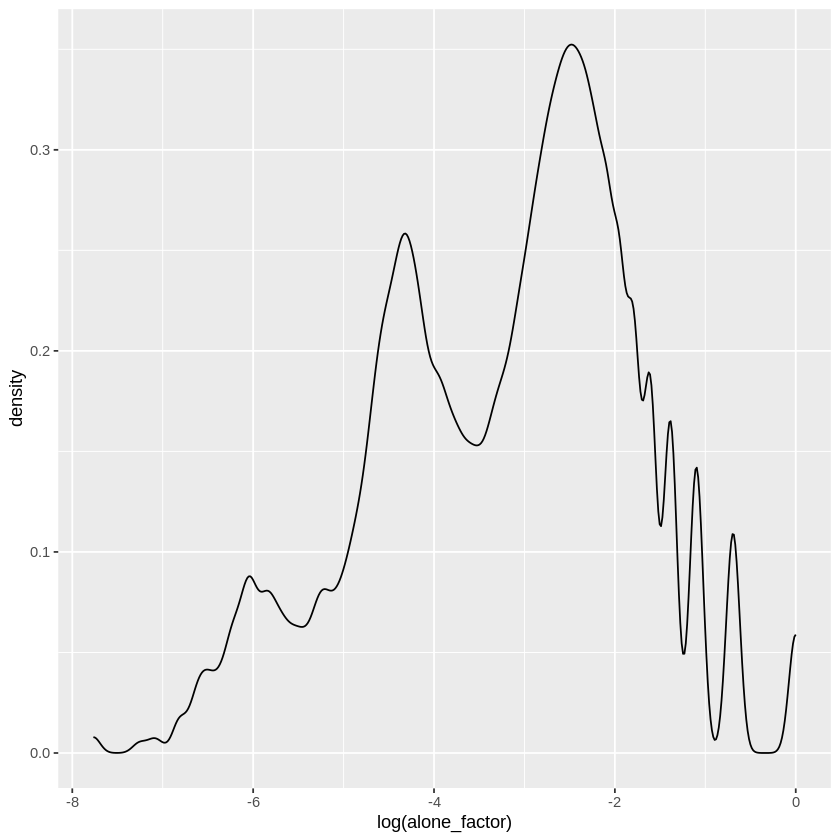

In [9]:
# Plotting the result
ggplot(my_table, aes(x = alone_factor)) +
  geom_density()

ggplot(my_table, aes(x = log(alone_factor))) +
  geom_density()

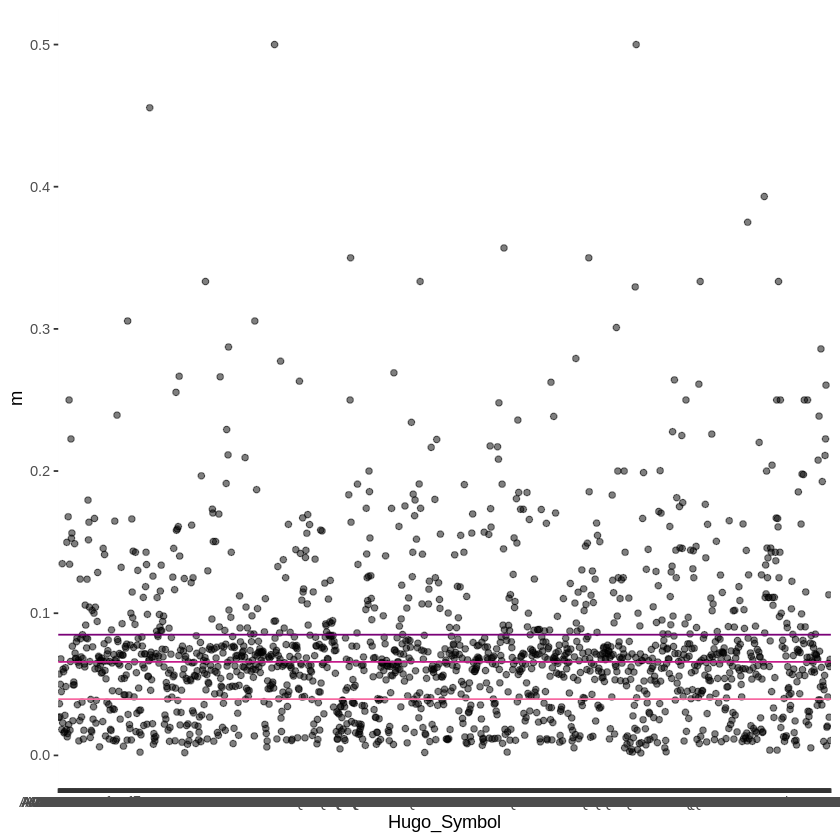

In [10]:
mean <- group_by(my_table, Hugo_Symbol) %>% summarize(m = mean(alone_factor))

#quantile(mean$m, probs = seq(0, 1, 0.25))

ggplot(mean, aes(x = Hugo_Symbol, y = m)) +
geom_point(alpha=0.5) +
geom_hline(yintercept=c(0.0395757291022104,0.06578580947071,0.0848773450419186),
           color=c('#f768a1','#c51b8a','#7a0177'))

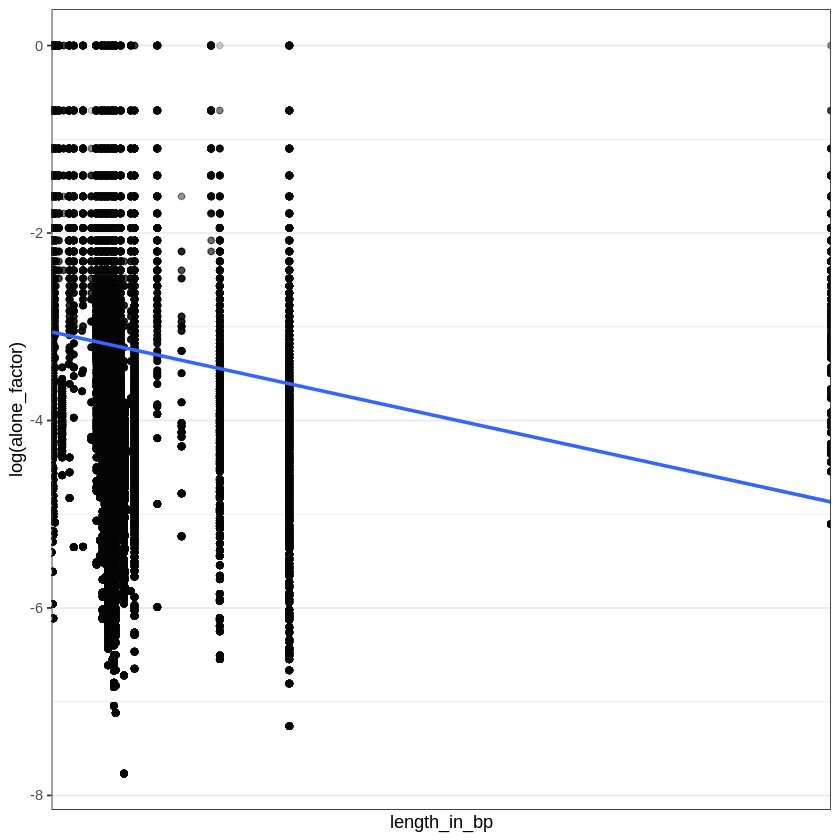

In [13]:
ggplot(my_table, aes(x=length_in_bp, y=log(alone_factor))) +
  geom_point(alpha=0.1) +
  scale_x_discrete(guide = guide_axis(angle = -90)) +
  geom_smooth(method='lm', formula=y ~ x) +
  theme_bw()

In [25]:
fwrite(list(mean$Hugo_Symbol), "../../derived_data/genie_v15/mutation_names.csv")